## Group 42 Project Report : The Classification of Wine Quality

### Introduction

White wine is one of the oldest and most cherished alcoholic beverages known to humanity. It is not merely a drink; it is a wonderful interaction between flavors and aromas, a product of nature's alchemy and human craftsmanship that is commonly enjoyed before a meal, with dessert, or as a refreshing drink between meals. White wine is known for its light and refreshing taste, which sets it apart from many of its red wine counterparts. Due to its acidity and aroma, white wine is also useful in cooking, helping to soften meat and enhance the flavors of various dishes. The essence of white wine lies in its quality, a multifaceted concept that encompasses various chemical components and sensory attributes. 

This study delves into the complexity of wine quality, using a systematic approach to assess white wines on a scale of 1 to 10.  Our research focuses on five fundamental chemical properties: pH, density, alcohol content, residual sugar content, and citric acid. As each of these elements plays a crucial role in shaping the taste, aroma, and overall character of the wine, we would like to build a model to predict the score of wine quality by the five properties.

This project uses the Wine Quality dataset of the white variant of the Portuguese "Vinho Verde" wine. This dataset contains 4898 observations of white wine with 12 attributes for each observation, however, only 6 of the attributes will be used for this classification project. This particular dataset contains no missing values.


#### Research question: Can a wine’s quality be accurately predicted on a scale of 1 to 10 based on its pH, density, alcohol content, residual sugar content, and citric acid?

To begin thinking about how to approach this question, we must first take a look at the raw data set. We will first load in a few useful packages for loading and working with our data set.

In [1]:
install.packages("kknn")
library(tidyverse)
library(repr)
library(tidymodels)
library(rvest)
library(GGally)
library(kknn)
options(repr.matrix.max.rows = 8)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks strin

ERROR: Error in library(GGally): there is no package called ‘GGally’


### 1. Read Data
Before we begin working with the data, we must load it into R from the web. The url for this dataset is https://archive.ics.uci.edu/static/public/186/wine+quality.zip.

In [2]:
url <- "https://raw.githubusercontent.com/RachelX6/DSCI100-Group-Project/main/winequality-white.csv"
white_wine_data <- read_delim(url, delim = ";") |>
        drop_na()

Rows: 4898 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
dbl (12): fixed acidity, volatile acidity, citric acid, residual sugar, chlo...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### 2. Wrangling and Cleaning

In [3]:
colnames(white_wine_data) <- c("fixed_acidity", # Adjusting column names for cleanliness.
              "volatile_acidity",
              "citric_acid",
              "residual_sugar",
              "chlorides",
              "free_sulfur_dioxide",
              "total_sulfur_dioxide",
              "density",
              "pH",
              "sulphates",
              "alcohol",
              "quality")

white_wine_data <- white_wine_data |>      # Changing the column "quality" into factor
    mutate(quality = as_factor(quality))

paste("Table 1. Glimpse of the White Wine Data")
head(white_wine_data, n = 5)

[1] "Table 1. Glimpse of the White Wine Data"

fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
7.0,0.27,0.36,20.7,0.045,45,170,1.0010,3.00,0.45,8.8,6
6.3,0.30,0.34,1.6,0.049,14,132,0.9940,3.30,0.49,9.5,6
8.1,0.28,0.40,6.9,0.050,30,97,0.9951,3.26,0.44,10.1,6
7.2,0.23,0.32,8.5,0.058,47,186,0.9956,3.19,0.40,9.9,6
7.2,0.23,0.32,8.5,0.058,47,186,0.9956,3.19,0.40,9.9,6


Above is the first five rows of the cleaned data.
A brief description of each column in the dataset is as follows:
- `fixed_acidity` -> The mass of fixed acid in the wine (g(tartaric acid)/dm$^{3}$).
- `volatile_acidity` -> The mass of volatile acid in the wine (g(acetic acid)/dm$^{3}$).
- `citric_acid` -> The mass of citric acid in the wine (g/dm$^{3}$).
- `residual_sugar` -> The mass of residual sugar in the wine (g/dm$^{3}$).
- `chlorides` -> The mass of chlorides in the wine (g(sodium chloride)/dm$^{3}$).
- `free_sulfur_dioxide` -> The mass of free sulfur dioxide in the wine (mg/dm$^{3}$).
- `total_sulfur_dioxide` -> The mass of total sulfur dioxide in the wine (mg/dm$^{3}$).
- `density` -> The overall density of the wine (g/cm$^{3}$).
- `pH` -> The pH of the wine (1-14).
- `sulphates` -> The mass of sulphates in the wine (g(potassium sulphate)/dm$^{3}$).
- `alcohol` -> The volume % alcohol content of the wine.

The last column, `quality`, is a rating on a scale from 1 to 10 of the wine's determined quality based on the given physicochemical factors.

In [4]:
set.seed(420)
# Creating the training and testing split of the data
wine_split <- initial_split(white_wine_data, prop = .75, strata = quality)
wine_train <- training(wine_split)
wine_test <- testing(wine_split)

### 3. Summarizing the Data
To summarize our training data, we 
1. count the number of observations for each quality of wine
2. calculate the mean of each predictor for each quality.

Note: There is no missing value.

In [5]:
# Count the number of observations
wine_qual_counts <- wine_train |>
            group_by(quality) |>
            summarize(count = n())
paste("Table 2. Wine Quality Count")
wine_qual_counts

[1] "Table 2. Wine Quality Count"

quality,count
<fct>,<int>
3,16
4,130
5,1082
6,1649
7,662
8,130
9,3


From the table we can see that only white wines of qualities 3 through 9 are present in the table, and there is a **class imbalance** in the dataset since it has many more counts of samples in classes 5 to 7 than others.

In [6]:
wine_samp_m <- wine_train |>
    group_by(quality) |>
    summarize(across(everything(), list(mean)))
paste("Table 3. Predictors Mean")
wine_samp_m

[1] "Table 3. Predictors Mean"

quality,fixed_acidity_1,volatile_acidity_1,citric_acid_1,residual_sugar_1,chlorides_1,free_sulfur_dioxide_1,total_sulfur_dioxide_1,density_1,pH_1,sulphates_1,alcohol_1
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3,7.700000,0.3371875,0.3281250,6.306250,0.05737500,60.21875,181.0000,0.9951231,3.195000,0.4793750,10.218750
4,7.056923,0.3756923,0.3041538,4.693077,0.05079231,24.58462,128.0346,0.9942445,3.184462,0.4787692,10.167308
5,6.942144,0.2990388,0.3352033,7.376941,0.05203882,36.40804,151.0915,0.9952766,3.168457,0.4831516,9.807301
6,6.816798,0.2602971,0.3388296,6.456125,0.04532444,35.69982,137.5058,0.9939414,3.187538,0.4879200,10.569153
7,6.732100,0.2637009,0.3251662,5.035347,0.03828550,33.96752,124.9343,0.9923626,3.212175,0.5010725,11.393630
8,6.554615,0.2768077,0.3300000,5.576538,0.03777692,37.04615,125.4769,0.9920865,3.227308,0.4984615,11.705385
9,7.800000,0.2900000,0.3833333,5.600000,0.02800000,37.33333,127.3333,0.9924500,3.253333,0.4333333,11.866667


(Explanation of the table)

### 4. Visualizing the Data

`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?
`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


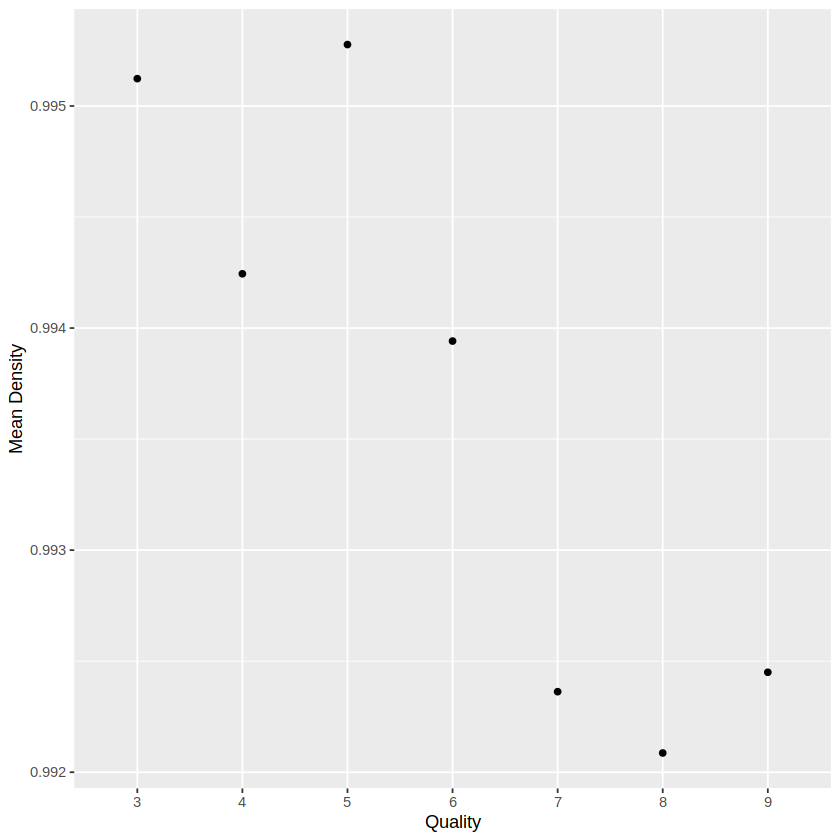

`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


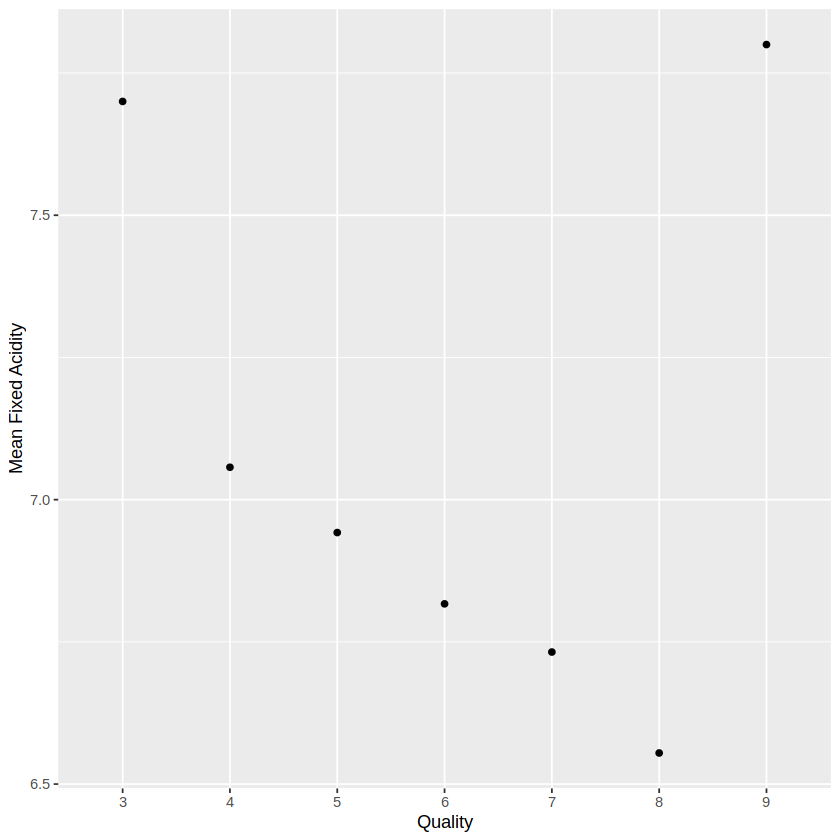

`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


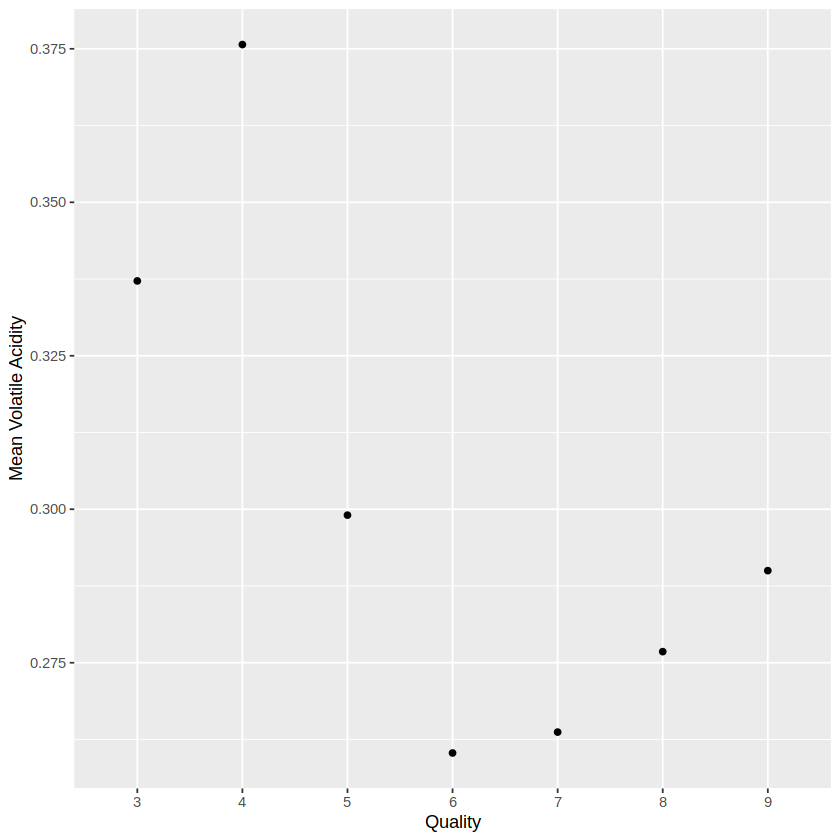

`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


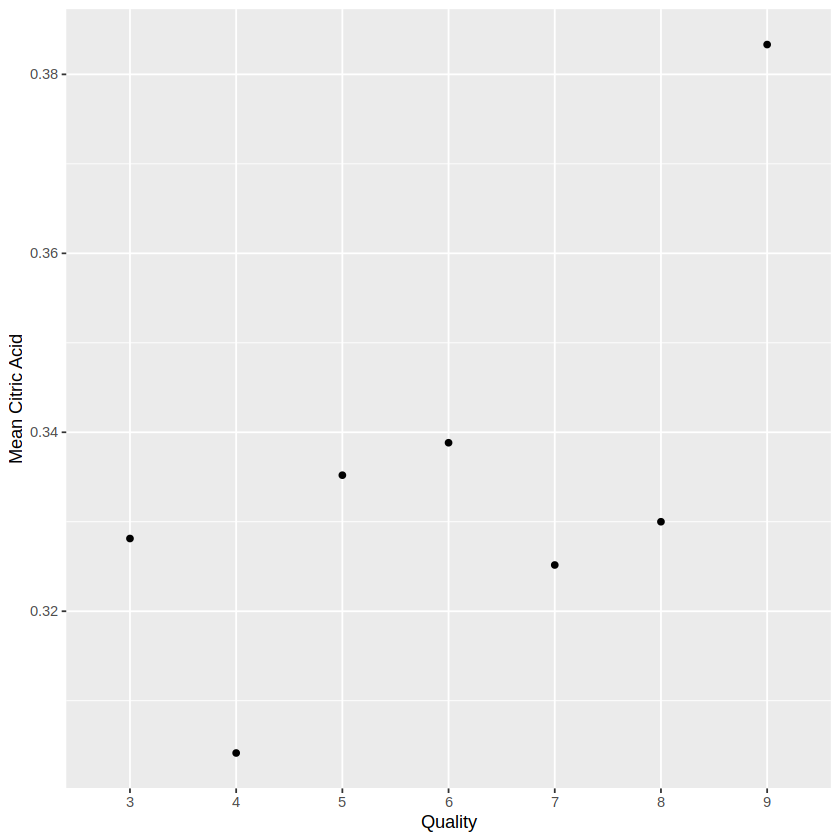

`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


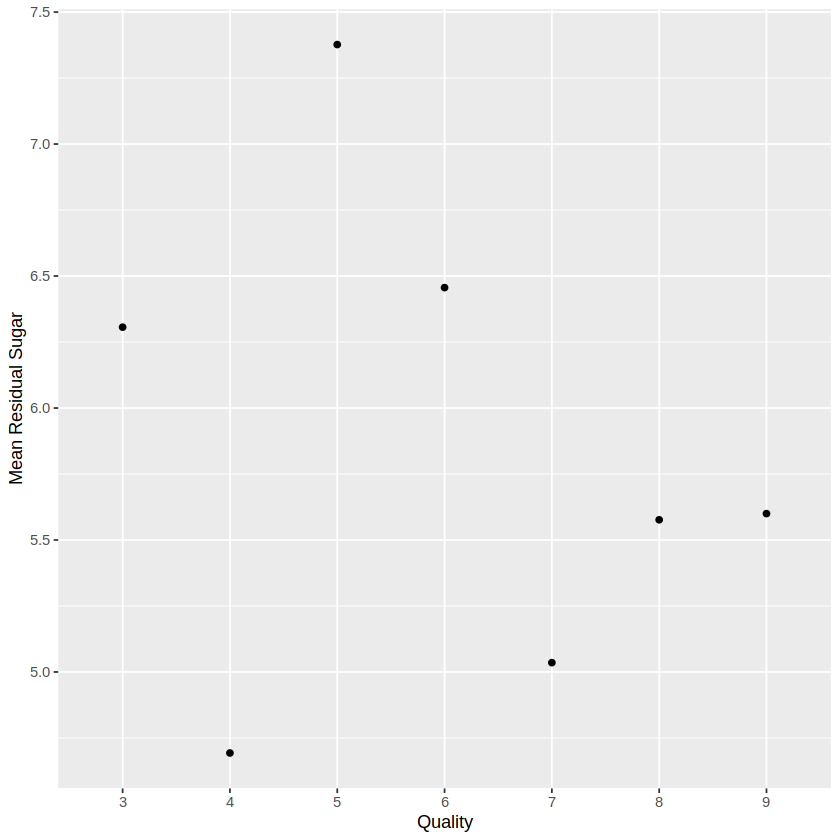

`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


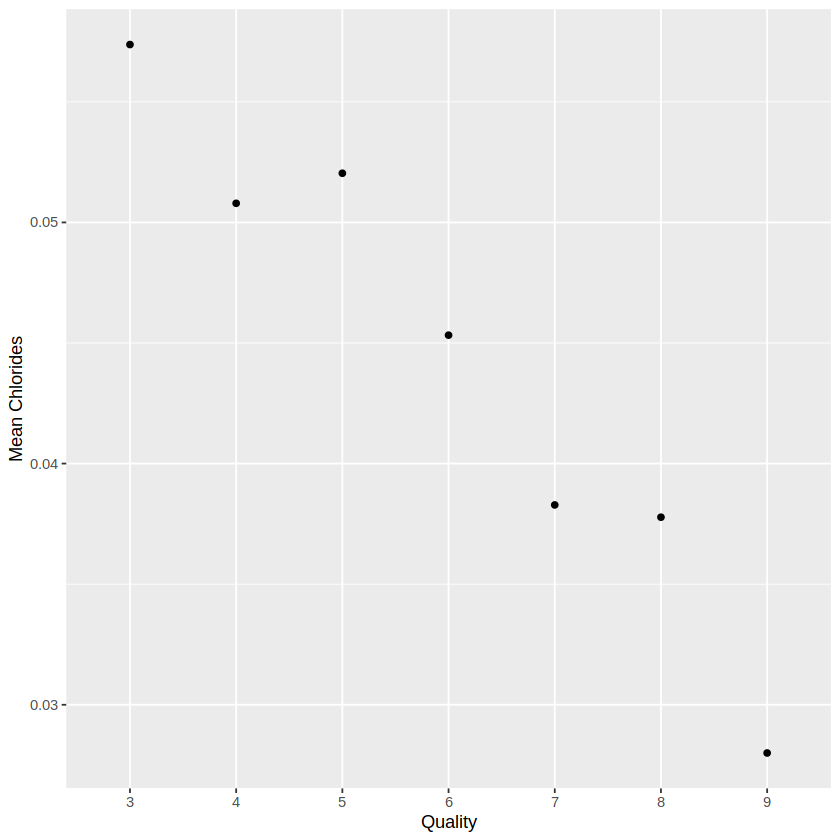

`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


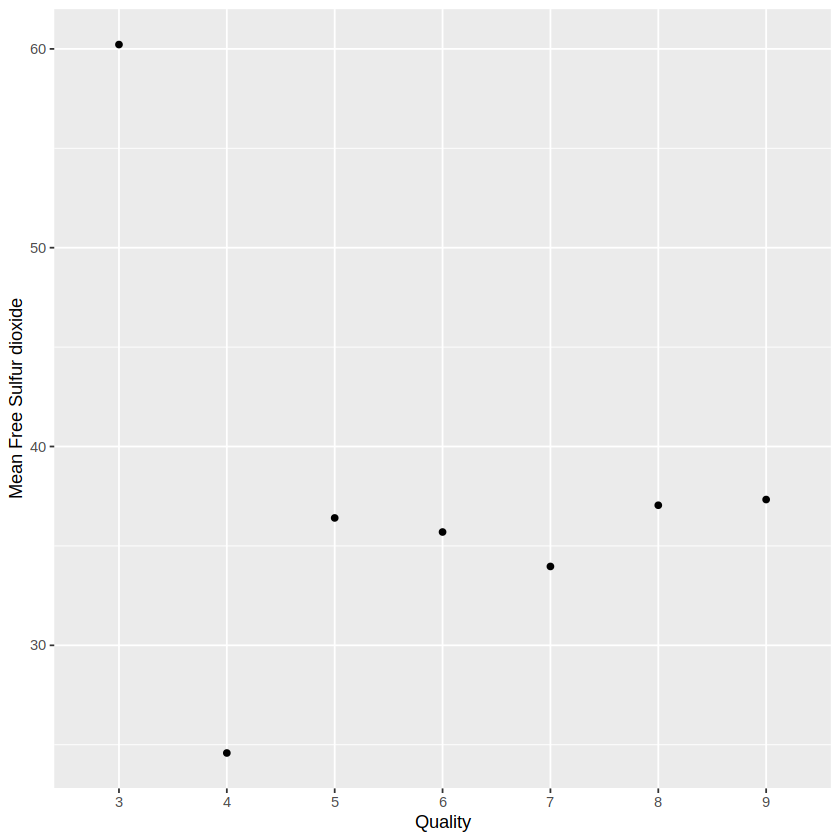

`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


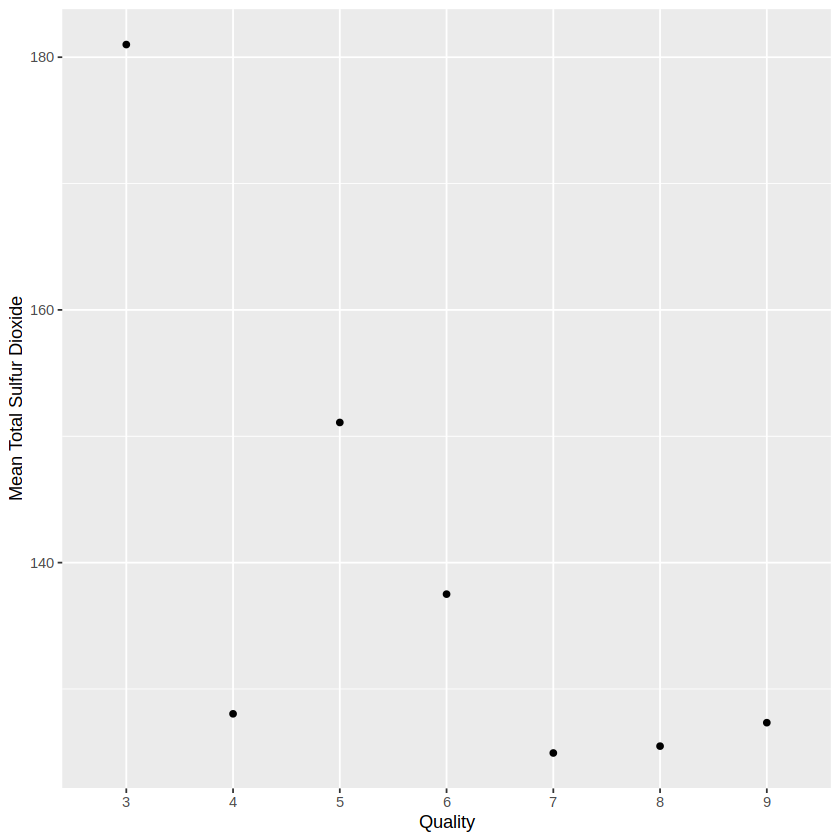

`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


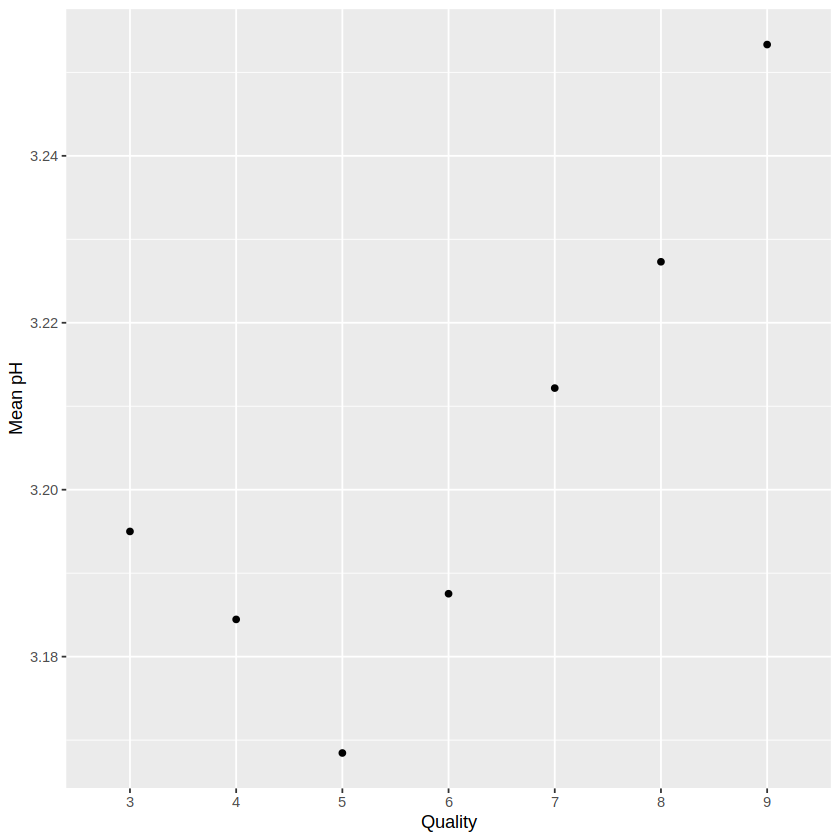

`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


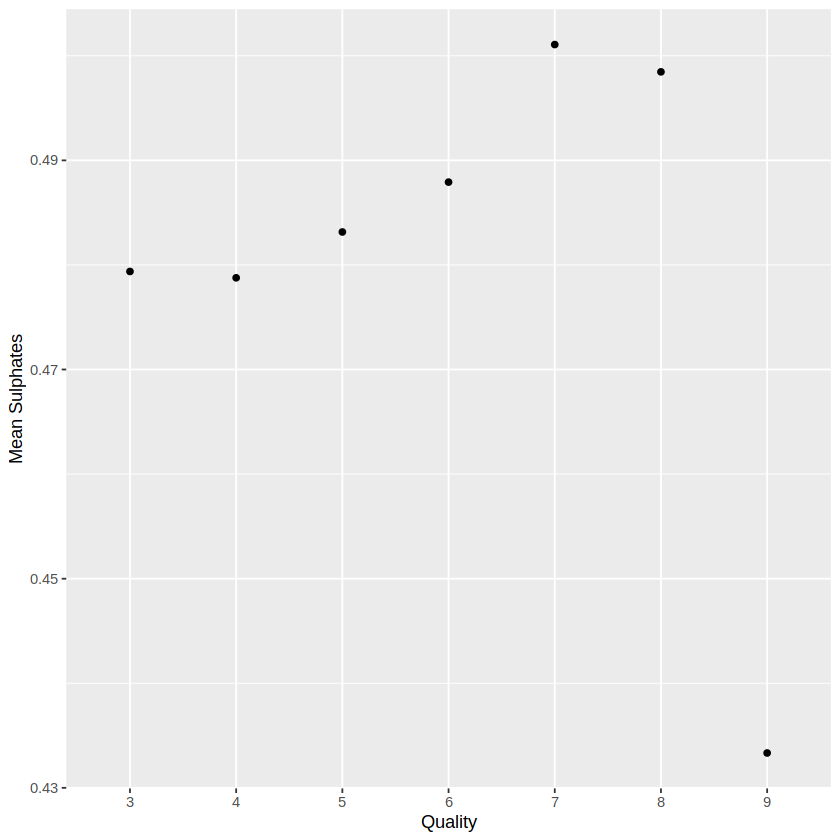

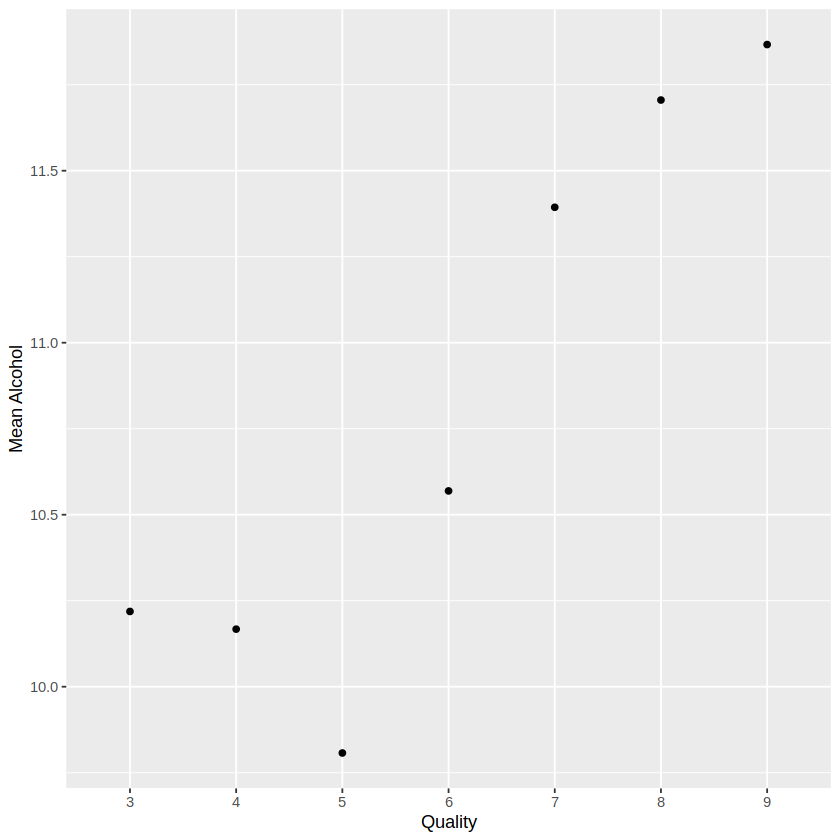

In [7]:
ggplot(wine_samp_m, aes(x= quality, y = density_1)) +
    geom_point() +
    geom_line() +
    labs(y = "Mean Density", x = "Quality")
ggplot(wine_samp_m, aes(x= quality, y = fixed_acidity_1)) +
    geom_point() +
    geom_line() +
    labs(y = "Mean Fixed Acidity", x = "Quality")
ggplot(wine_samp_m, aes(x= quality, y = volatile_acidity_1)) +
    geom_point() +
    geom_line() +
    labs(y = "Mean Volatile Acidity", x = "Quality")
ggplot(wine_samp_m, aes(x= quality, y = citric_acid_1)) +
    geom_point() +
    geom_line() +
    labs(y = "Mean Citric Acid", x = "Quality")
ggplot(wine_samp_m, aes(x= quality, y = residual_sugar_1)) +
    geom_point() +
    geom_line() +
    labs(y = "Mean Residual Sugar", x = "Quality")
ggplot(wine_samp_m, aes(x= quality, y = chlorides_1)) +
    geom_point() +
    geom_line() +
    labs(y = "Mean Chlorides", x = "Quality")
ggplot(wine_samp_m, aes(x= quality, y = free_sulfur_dioxide_1)) +
    geom_point() +
    geom_line() +
    labs(y = "Mean Free Sulfur dioxide", x = "Quality")
ggplot(wine_samp_m, aes(x= quality, y = total_sulfur_dioxide_1)) +
    geom_point() +
    geom_line() +
    labs(y = "Mean Total Sulfur Dioxide", x = "Quality")
ggplot(wine_samp_m, aes(x= quality, y = pH_1)) +
    geom_point() +
    geom_line() +
    labs(y = "Mean pH", x = "Quality")
ggplot(wine_samp_m, aes(x= quality, y = sulphates_1)) +
    geom_point() +
    geom_line() +
    labs(y = "Mean Sulphates", x = "Quality")
ggplot(wine_samp_m, aes(x= quality, y = alcohol_1)) +
    geom_point() +
    geom_line() +
    labs(y = "Mean Alcohol", x = "Quality")

From the visualization, we are not able to see the relationship of each predictors and the quality of wine mainly due to the **class imbalance** that we observed before, so in the next section we try to deal with it before doing the actual data analysis.

### 5. Class Imbalance